# 3. Sampling the imaginary

In [66]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, vmap
from scipy.stats import gaussian_kde

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

cm=1/2.54 # centimeters in inches
px=1/plt.rcParams['figure.dpi'] # pixel in inches

%pprint # turn on/off pprint

Pretty printing has been turned ON


In [2]:
# Pr(sig|true) = 0.95  - tru-positev rate, power of the test, prob of positive finding when hypotheses are true
# Pr(sig|false) = 0.05 - false-positive rate, prov of positive finding when hypotheses are false
# Pr(true) = 0.01      - base rate at which hypotheses are true. 1 in 100 hypotheses turns out to be true.

In [116]:
def standardize(array): return array / jnp.sum(array)
p_grid = jnp.linspace(start=0, stop=1, num=1000)

def compute_posterior(N, W):
    prior = standardize(jnp.repeat(1, len(p_grid)))
    # R: likelihood <- dbinom(W, size=N, prob=p_grid)
    likelihood = jnp.exp(dist.Binomial(total_count=N, probs=p_grid).log_prob(W))
    return standardize(likelihood * prior)

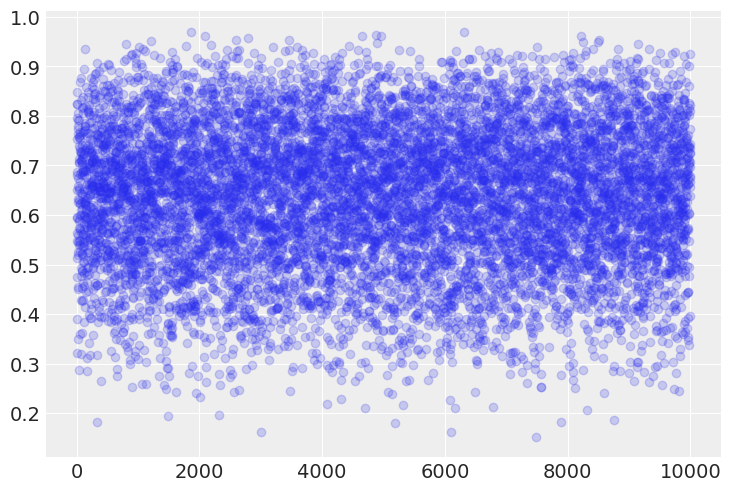

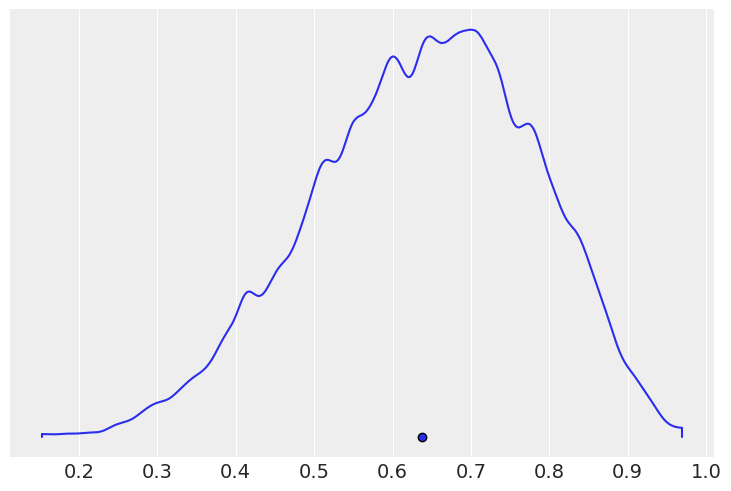

In [120]:
# Code 3.2
posterior = compute_posterior(9, 6)

# Code 3.3
# R: samples <- sample(p_grid, prob=posterior, size=1e4, replace=TRUE)
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

# Code 3.4
plt.scatter(range(len(samples)), samples, alpha=0.2)
plt.show()

# Code 3.5
az.plot_density({"": samples}, hdi_prob=1)
plt.show()

In [113]:
posterior = compute_posterior(9, 6)
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

# Code 3.6
# add up posterior probability where p < 0.5
print(jnp.sum(posterior[p_grid < 0.5]))

# Code 3.7, Posterior(p < 0.5)
print(jnp.sum(samples < 0.5) / len(samples))

# Code 3.8, Posterior(0.5 < p < 0.75)
print(jnp.sum((samples > 0.5) & (samples < 0.75)) / len(samples))

0.17187458
0.1711
0.6025


In [121]:
def fill_interval(X, Y, interval, title):
    low, hi = interval
    plt.title(title)
    plt.xlabel("proportion of water(p)")
    plt.ylabel("Density")
    plt.plot(X, Y)
    plt.fill_between(X, Y, where=((X > low) & (X < hi)))

quantile(0.1, 0.9) =[0.446446 0.816817]
percentile(10, 90) =[0.446446 0.816817]


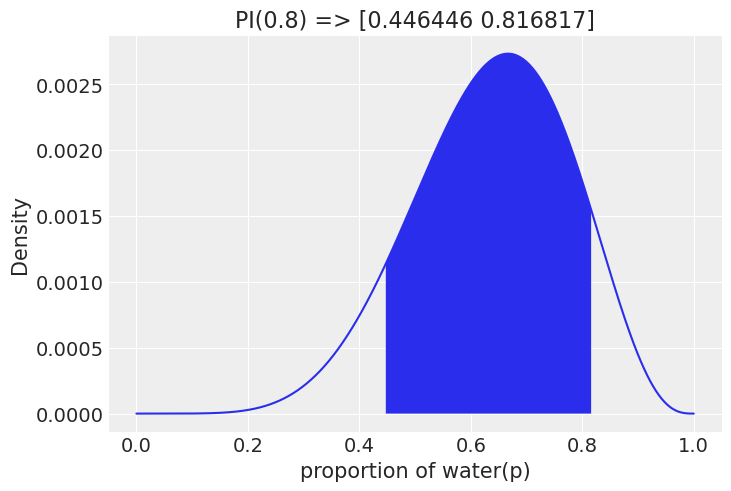

In [143]:
posterior = compute_posterior(9, 6)
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

# Code 3.9
lo, hi = jnp.quantile(samples, jnp.array([0.1, 0.9]))
print("quantile(0.1, 0.9) =[%f %f]" % (lo, hi))
fill_interval(p_grid, posterior, (lo, hi), "PI(0.8) => [%f %f]" % (lo, hi))

lo, hi = jnp.percentile(samples, q=jnp.array([10, 90]))
print("percentile(10, 90) =[%f %f]" % (lo, hi))


plt.show()

MAP= 1.0
MAP(samples) = 0.988989
mean= 0.8011085
median= 0.8428428


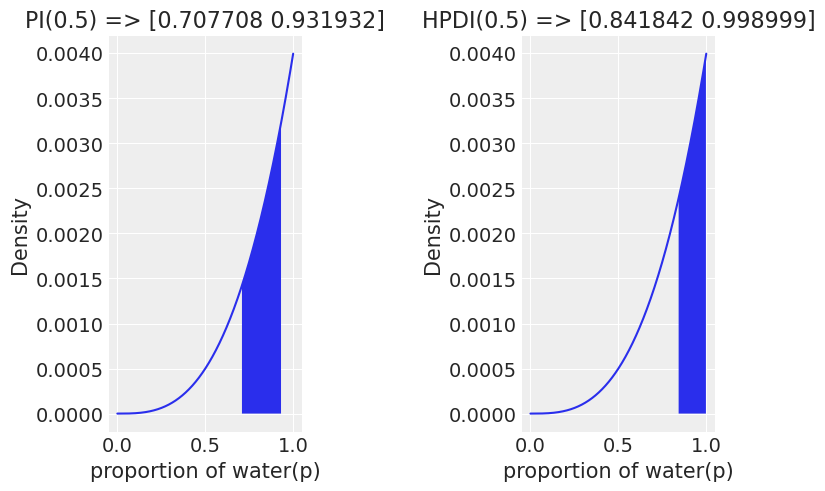

In [127]:
# Code 3.11
posterior = compute_posterior(3, 3)
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]


# Code 3.12, 50% of percentile compatibility interval
# R: PI( samples,prob=0.5), 
lo, hi = jnp.percentile(samples, q=jnp.array([25, 75]))
plt.subplot(131)
fill_interval(p_grid, posterior, (lo, hi), "PI(0.5) => [%f %f]" % (lo, hi))

# Code 3.13, highest posterior density interval
# R: HPDI( samples, prob=0.5 )
lo, hi = numpyro.diagnostics.hpdi(samples, prob=0.5)
plt.subplot(133)
fill_interval(p_grid, posterior, (lo, hi), "HPDI(0.5) => [%f %f]" % (lo, hi))

# Code 3.14, maximum a posteriori
# R: p_grid[ which.max(posterior) ]
print("MAP=", p_grid[jnp.argmax(posterior)])

# Code 3.15
# R: chainmode( samples,adj=0.01)
print("MAP(samples) =", samples[jnp.argmax(gaussian_kde(samples, bw_method=0.01)(samples))])

# Code 3.16
print("mean=", jnp.mean(samples))
print("median=", jnp.median(samples))

plt.show()

In [69]:
# Code 3.17
print("loss(abs) = ", jnp.sum(posterior * jnp.abs(0.5 - p_grid)))

# Code 3.18, list of loss values
# R: loss <- sapply( p_grid, function(d) sum(posterior*abs( d - p_grid ) ) )
loss = vmap(lambda d: jnp.sum(posterior * jnp.abs(d - p_grid)))(p_grid)

# Code 3.19
# R: p_grid[ which.min(loss)]
print("median(loss abs)=", p_grid[jnp.argmin(loss)] )

# Code 3.20
print( jnp.exp(dist.Binomial(total_count=2, probs=0.7).log_prob(jnp.arange(3))) )


loss(abs) =  0.31287518
median(loss abs)= 0.8408408
[0.09000004 0.42000008 0.49000022]


In [74]:
# Code 3.20
# R: dbinom( 0:2, size=2, prob=0.7 )
print("dbinom=", jnp.exp(dist.Binomial(total_count=2, probs=0.7).log_prob(jnp.arange(3))) )

# Code 3.21
# R: rbinom( 1,size=2,prob=0.7)
print("rbinom (1 toss)=", dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(0)) )

# Code 3.22
# R: rbinom( 10,size=2,prob=0.7)
print("rbinom (10 tosses)=", dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(2), (10,)) )

dbinom= [0.09000004 0.42000008 0.49000022]
rbinom (1 toss)= 1
rbinom (10 tosses)= [2 1 2 1 1 2 2 2 2 1]


In [75]:
# Code 3.23
dummy_w = dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(0), (100000,))
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([0.0888 , 0.41789, 0.49331], dtype=float32, weak_type=True)

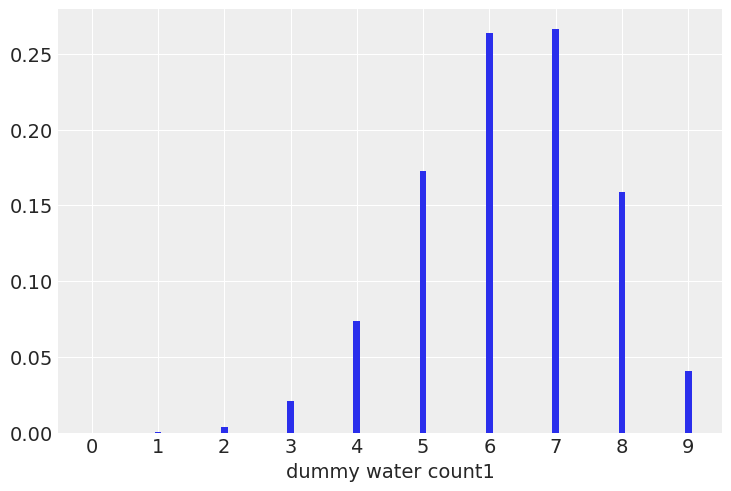

In [82]:
# Code 3.24
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(random.PRNGKey(0), (100000,))
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show() 

In [85]:
# Code 3.25
# R: w <-rbinom(1e4,size=9,prob=0.6)
w = dist.Binomial(total_count=9, probs=0.6).sample(random.PRNGKey(0), (int(1e4),))
print(w)

# Code 3.26
# R: w <-rbinom(1e4,size=9,prob=samples)
w = dist.Binomial(total_count=9, probs=samples).sample(random.PRNGKey(0))
print(w)

# Code 3.27


[5 6 6 ... 5 4 7]
[9 7 2 ... 8 9 8]


# -------------------------------------------------------------
# Practice

In [182]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = standardize( jnp.repeat(1, 1000))
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
posterior = standardize( likelihood * prior )

samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]
# 3E1. How much posterior probability lies below p = 0.2?
print("Posterior(p<0.2)    =", jnp.sum(samples<0.2) / len(samples))

# 3E2. How much posterior probability lies above p = 0.8?
print("Posterior(p>0.8)    =", jnp.sum(jnp.sum(samples>0.8) / len(samples)) )

# 3E3. How much posterior probability lies p =[0.2 , 0.8]?
print("Posterior(0.2<p<0.8)=", jnp.sum(jnp.sum((samples > .2) & (samples < .8)) / len(samples)) )

# 3E4. 20% of the posterior probability lies below which value of p?
print("percentile(20)=", jnp.quantile(samples, 0.2))

# 3E5. 20% of the posterior probability lies above which value of p?
print("percentile(80)=", jnp.quantile(samples, 0.8))

# 3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?
print("HDPI(0.66)=", numpyro.diagnostics.hpdi(samples, prob=0.66))

# 3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both be low and above the interval?
print("PI(0.66)  =", jnp.percentile(samples, q=jnp.array([17, 100-17])))

Posterior(p<0.2)    = 0.001
Posterior(p>0.8)    = 0.121
Posterior(0.2<p<0.8)= 0.878
percentile(20)= 0.5185185
percentile(80)= 0.7607607
HDPI(0.66)= [0.5155155 0.7847848]
PI(0.66)  = [0.50233227 0.7737738 ]


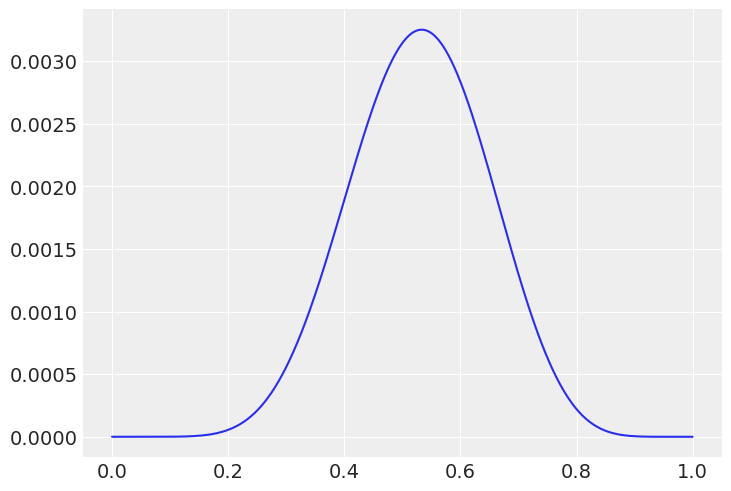

In [185]:
# 3M1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. 
# Construct theposterior distribution, using grid approximation. Use the same flat prior as before.
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = standardize( jnp.repeat(1, 1000))
likelihood = jnp.exp(dist.Binomial(total_count=15, probs=p_grid).log_prob(8))
posterior = standardize( likelihood * prior )

samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]
plt.plot(p_grid, posterior)

HDPI(0.9)= [0.33333334 0.7187187 ]
0.1443
0.1763


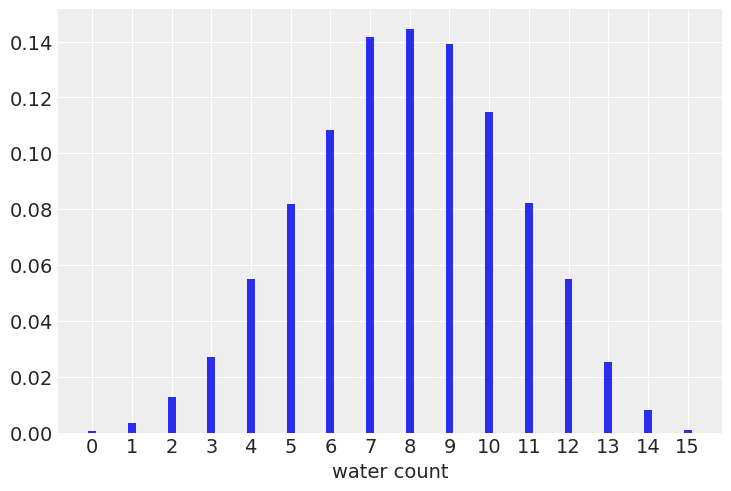

In [198]:
# 3M2
print("HDPI(0.9)=", numpyro.diagnostics.hpdi(samples, prob=0.9) )

# 3M3. Construct a posterior predictive check for this model and data.This means simulate the distribution of samples,
#    averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?
# R: w <- rbinom(1e4, size=15, prob=samples)
w = dist.Binomial(total_count=15, probs=samples).sample(random.PRNGKey(0))
print(jnp.sum(w == 8) / len(w) )

ax = az.plot_dist(w.copy(), kind="hist", hist_kwargs={"rwidth": 0.2})
ax.set_xlabel("water count", fontsize=14)

# 3M4.
w = dist.Binomial(total_count=9, probs=samples).sample(random.PRNGKey(0))
print(jnp.sum(w == 6) / len(w) )

plt.show()

33 / 100 : 0.237237
95 / 300 : 0.137137
157 / 500 : 0.106106
218 / 700 : 0.090090
279 / 900 : 0.079079
340 / 1100 : 0.071071
401 / 1300 : 0.066066
461 / 1500 : 0.061061
522 / 1700 : 0.057057
583 / 1900 : 0.054054
643 / 2100 : 0.052052
** 704 / 2300 : 0.049049


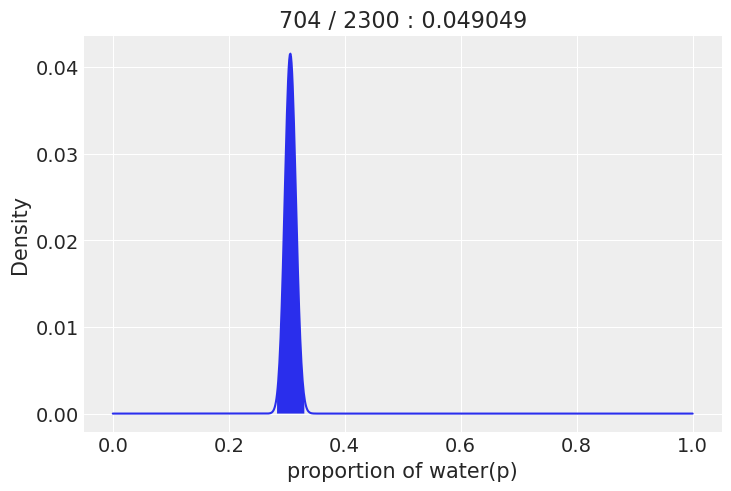

In [262]:
# 3M6 Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. 
# This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this?

# see https://gregor-mathes.netlify.app/2020/07/31/rethinking-chapter-3/#medium-practices
# This is going to be tricky. We need to simulate sample sizes, and then iteratively apply a function that calculates the 99% percentile interval to these sample sizes. Let’s define the function:
# generate diffrent samples count

p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = standardize( jnp.repeat(1, 1000))

random_gen = random.PRNGKey(100)
for N in range(100, 3000, 200):
    W = dist.Binomial(total_count=N, probs=0.3).sample(random_gen, (int(1),))[0]

    #posterior = standardize( prior * jnp.exp(dist.Binomial(total_count=N, probs=p_grid).log_prob(W)) )
    # analytical, using Beta
    posterior = standardize ( jnp.exp(dist.Beta(W + 1, (N-W) + 1).log_prob(p_grid)) )
    
    samples = p_grid[dist.Categorical(posterior).sample(random_gen, (10000,))]
    
    lo, hi = numpyro.diagnostics.hpdi(samples, prob=0.99)
    #lo, hi = jnp.quantile(samples, jnp.array([0.005, 0.995]))
    if abs(hi - lo) < 0.05:
        print ("** %d / %d : %f" % (W, N, hi - lo))
        
        fill_interval(p_grid, posterior, (lo, hi), "%d / %d : %f" % (W, N, hi - lo))
        plt.show()
        break
    else:
        print ("%d / %d : %f" % (W, N, hi - lo))


In [277]:
# The Hard problems here all use the data below. These data indicate the gender (male = 1, female = 0) of officially reported first and second born children in 100 two-child families.

birth1 = jnp.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = jnp.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0])

boys, girls = sum(birth1) + sum(birth2), len(birth1) + len(birth2)
print("boys, girs = [%d, %d]" % (boys, girls))

# 3H1 Using grid approximation, compute the posterior distribution for the probability of a birth being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = standardize( jnp.repeat(1, 1000))

posterior = standardize (prior * jnp.exp(dist.Beta(boys + 1, girls + 1).log_prob(p_grid)) )
    
samples = p_grid[dist.Categorical(posterior).sample(random_gen, (10000,))]

print("MAP=", p_grid[jnp.argmax(posterior)])
print("HDPI: 50%", numpyro.diagnostics.hpdi(samples, prob=0.5))
print("HDPI: 89%", numpyro.diagnostics.hpdi(samples, prob=0.89))
print("HDPI: 97%", numpyro.diagnostics.hpdi(samples, prob=0.97))


boys, girs = [111, 200]
MAP= 0.35735735
HDPI: 50% [0.33433434 0.37037036]
HDPI: 89% [0.3153153 0.4004004]
HDPI: 97% [0.2972973 0.4154154]
